In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/code/uchicago/sociohydro/sim/meanField/SchellingMF`


In [2]:
using SchellingMF
using LinearAlgebra
using Distributions
using StatsBase
using Printf
using HDF5
using JSON
using ProgressMeter
using Plots
using LaTeXStrings
using BenchmarkTools
using DifferentialEquations

[ Info: Precompiling SchellingMF [32cf9677-621a-48fb-9dac-cb166cb73326]


In [3]:
Nx = 11
dx = 0.1
dt = 0.001
Nt = 5000
kaa = 0.0
kab = 0.0
kba = 0.0
kbb = 0.0
utility_params = [kaa, kab, kba, kbb]
D = 1.0
Γ = 0.1
order = 2
periodic = false
savepath = "/Users/danny/Google Drive/My Drive/uchicago/sociohydro/2023-11-30_2DTest"

ϕ0 = zeros(Nx, Nx, 2)
ϕ0[(Nx ÷ 2)-1:(Nx ÷ 2)+3, (Nx ÷ 2)-1:(Nx ÷ 2)+3, :] .= ones(5, 5)
t_init = 0.0

∇stencils = calc_grad_stencil(order)
∇²stencils = calc_lap_stencil(order)

if periodic
    ∇stencils = (∇stencils[1],)
    ∇²stencils = (∇²stencils[1],)
end

params = (; dx, utility_params, D, Γ, ∇stencils, ∇²stencils)
tspan = (0.0, Nt * dt)

prob = ODEProblem(calc_force!, ϕ0, tspan, params)

ODEProblem with uType Array{Float64, 3} and tType Float64. In-place: true
timespan: (0.0, 5.0)
u0: 11×11×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0

In [4]:
alg = TRBDF2(autodiff=false)
sol = solve(prob, alg, saveat=0.0:100*dt:dt*Nt);

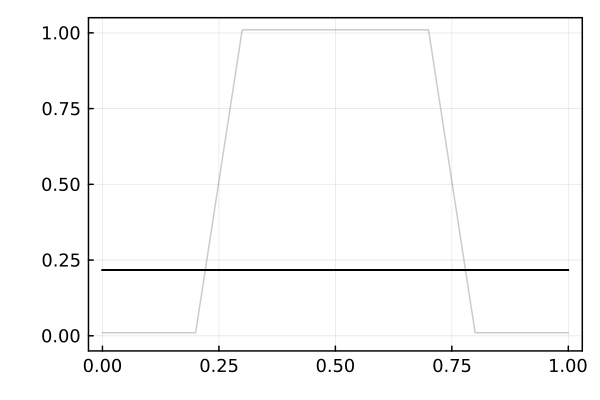

In [5]:
x = 0:dx:dx*(Nx-1)
p = plot(leg=false, ylim=[-0.05, 1.05], thickness_scaling=1.5, framestyle=:box)
plot!(x, [sol.u[i][Nx÷2, :, 1] .+ 0.01 for i in 1:length(sol.u)],
      color=:black, alpha=0.2)

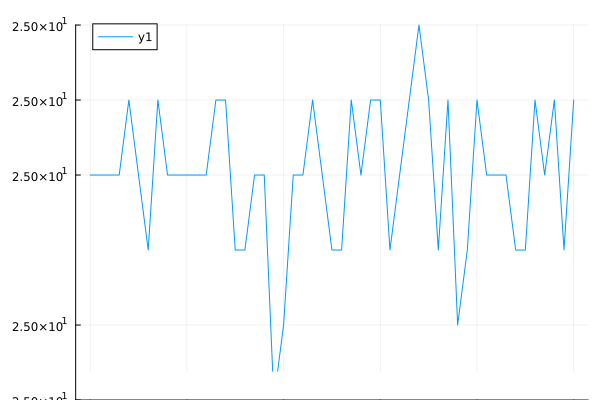

In [9]:
plot(sol.t, [sum(sol.u[i][:, :, 1]) for i in 1:length(sol.t)])

In [7]:
[sum(sol.u[i][:, :, 1]) for i in 1:length(sol.t)]

51-element Vector{Float64}:
 25.0
 25.0
 25.0
 25.0
 25.000000000000004
 25.0
 24.999999999999996
 25.000000000000004
 25.0
 25.0
 25.0
 25.0
 25.0
  ⋮
 24.999999999999996
 25.000000000000004
 25.0
 25.0
 25.0
 24.999999999999996
 24.999999999999996
 25.000000000000007
 25.0
 25.000000000000004
 24.999999999999996
 25.000000000000004

# test gradients

In [2]:
Nx = 100
L = 4π
dx = L/Nx
x = -(L/2):dx:(L/2)
y = -(L/2):dx:(L/2)
xx = ones(length(y)) * x';
yy = y * ones(length(x))';

Nx = length(x);

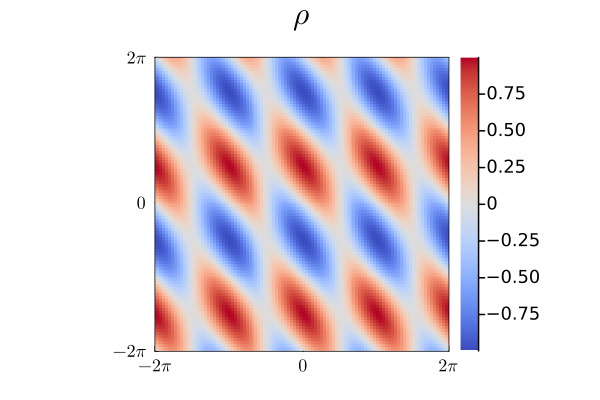

In [33]:
# true distribution
rho = @. cos(xx) * sin(yy + xx);
rhox_true = @. cos(xx) * cos(xx + yy) - sin(xx) * sin(yy + xx)
rhoy_true = @. cos(xx) * cos(xx + yy)
rholap_true = @. -2 * cos(xx + yy) * sin(xx) - 3 * cos(xx) * sin(xx + yy)
rhoxxx_true = @. 5 * (sin(xx) * sin(xx + yy) - cos(xx) * cos(xx + yy))
rhoyyy_true = @. 2 * sin(xx) * sin(xx + yy) - 3 * cos(xx) * cos(xx + yy)

h = heatmap(x, y, rho, cmap=:coolwarm, title=L"\rho")
plot(h, thickness_scaling=1.5, aspect_ratio=1, framestyle=:box,
         xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
         xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
         yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))

In [34]:
# get center, forward, and backward stencils at 4th order
order = 4
∇_stencils = calc_grad_stencil(order);
∇²_stencils = calc_lap_stencil(order);

In [44]:
rhox, rhoy = calc_grad(rho, dx, (∇_stencils[1],)...)
rholap = calc_lap(rho, dx, (∇²_stencils[1],)...)
rhoxxx, rhoyyy = calc_grad3(rho, dx, (∇_stencils[1],), (∇²_stencils[1],));

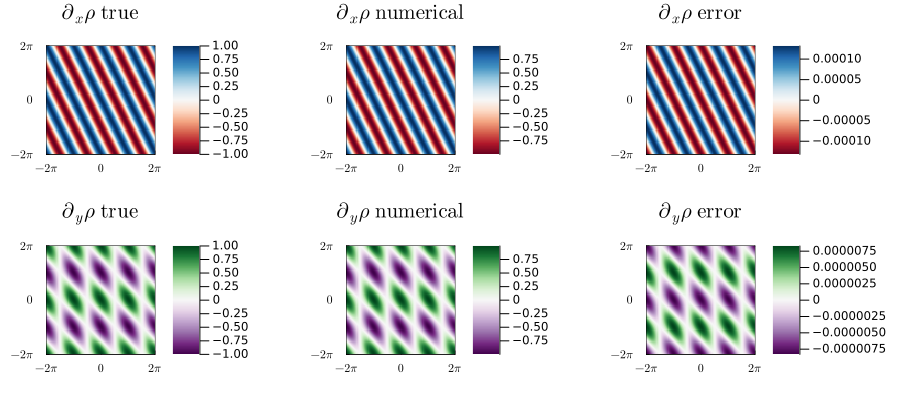

In [45]:
hx = heatmap(x, y, rhox, cmap=:RdBu, title=L"\partial_x \rho \ \mathrm{numerical}")
hxtrue = heatmap(x, y, rhox_true, cmap=:RdBu, title=L"\partial_x \rho \ \mathrm{true}")
hxerr = heatmap(x, y, rhox - rhox_true, cmap=:RdBu, title=L"\partial_x \rho \ \mathrm{error}")
hy = heatmap(x, y, rhoy, cmap=:PRGn, title=L"\partial_y \rho \ \mathrm{numerical}")
hytrue = heatmap(x, y, rhoy_true, cmap=:PRGn, title=L"\partial_y \rho \ \mathrm{true}")
hyerr = heatmap(x, y, rhoy - rhoy_true, cmap=:PRGn, title=L"\partial_y \rho \ \mathrm{error}")
l = @layout([[a b c]; [d e f]])
plot(hxtrue, hx, hxerr, hytrue, hy, hyerr, layout=l, size=(900, 400),
     thickness_scaling=1, aspect_ratio=1, framestyle=:box, right_margin=12Plots.mm,
         xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
         xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
         yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))

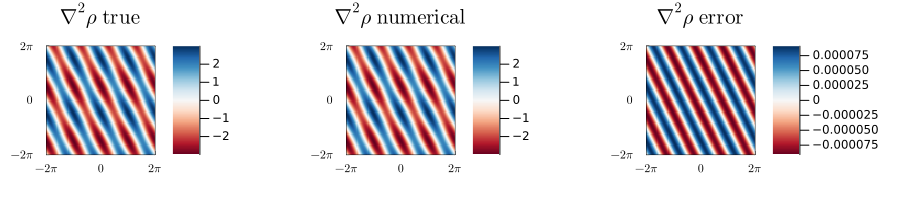

In [46]:
hlap = heatmap(x, y, rholap, cmap=:RdBu, title=L"\nabla^2 \rho \ \mathrm{numerical}")
hlaptrue = heatmap(x, y, rholap_true, cmap=:RdBu, title=L"\nabla^2 \rho \ \mathrm{true}")
herror = heatmap(x, y, rholap - rholap_true, cmap=:RdBu, title=L"\nabla^2 \rho \ \mathrm{error}")
l = @layout([a b c])
plot(hlaptrue, hlap, herror, layout=l, size=(900, 200),
     thickness_scaling=1.0, aspect_ratio=1, framestyle=:box, right_margin=12Plots.mm,
     xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
     xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
     yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))

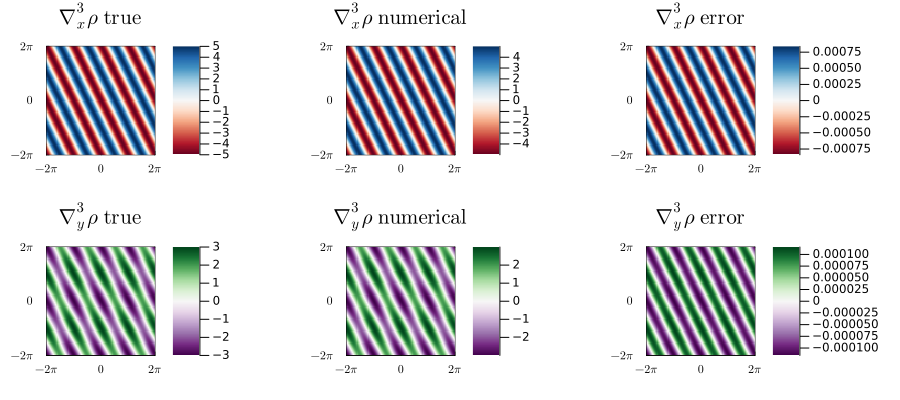

In [47]:
hx = heatmap(x, y, rhoxxx, cmap=:RdBu, title=L"\nabla^3_x \rho \ \mathrm{numerical}")
hxtrue = heatmap(x, y, rhoxxx_true, cmap=:RdBu, title=L"\nabla^3_x \rho \ \mathrm{true}")
hxerr = heatmap(x, y, rhoxxx_true - rhoxxx, cmap=:RdBu, title=L"\nabla^3_x \rho \ \mathrm{error}")
hy = heatmap(x, y, rhoyyy, cmap=:PRGn, title=L"\nabla^3_y \rho \ \mathrm{numerical}")
hytrue = heatmap(x, y, rhoyyy_true, cmap=:PRGn, title=L"\nabla^3_y \rho \ \mathrm{true}")
hyerr = heatmap(x, y, rhoyyy_true - rhoyyy, cmap=:PRGn, title=L"\nabla^3_y \rho \ \mathrm{error}")
l = @layout([[a b c]; [d e f]])
plot(hxtrue, hx, hxerr, hytrue, hy, hyerr, layout=l, size=(900, 400),
     thickness_scaling=1, aspect_ratio=1, framestyle=:box, right_margin=12Plots.mm,
         xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
         xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
         yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))

In [127]:
function initialize_grid(grid_size)
    return randn(grid_size, grid_size)
end

function laplacian(phi, dx)
    laplacian_phi = (circshift(phi, (0, 1)) + circshift(phi, (1, 0)) - 4*phi +
                     circshift(phi, (0, -1)) + circshift(phi, (-1, 0))) / dx^2
    return laplacian_phi
end

function update_cahn_hilliard!(phi, D, Gamma, dt, dx)
    laplacian_phi = laplacian(phi, dx)

    fourth_derivative_phi = laplacian(laplacian_phi, dx)

    phi .+= dt * (D * laplacian_phi - Gamma * fourth_derivative_phi)

    return phi
end

function apply_no_flux_boundary_conditions!(phi)
    phi[:, 1] .= phi[:, 2]  # Left boundary
    phi[:, end] .= phi[:, end-1]  # Right boundary
    phi[1, :] .= phi[2, :]  # Bottom boundary
    phi[end, :] .= phi[end-1, :]  # Top boundary
end

function main()
    grid_size = 64
    dx = 1.0 / grid_size
    D = 1.0
    Gamma = 1.0
    dt = 1e-3
    num_steps = 10000

    phi0 = initialize_grid(grid_size)
    phi = deepcopy(phi0)
    
    for step in 1:num_steps
        update_cahn_hilliard!(phi, D, Gamma, dt, dx)
        apply_no_flux_boundary_conditions!(phi)
        if any(isnan.(phi))
            println("nans at step " * string(step) * "/" * string(num_steps))
            break
        end
    end
    
    return phi, phi0
end


main (generic function with 1 method)

In [144]:
x = -3:dx:3
y = -3:dx:3
phi0 = reshape([exp(-(xx^2 + yy^2)) for xx in x for yy in y], length(x), length(y));
∇²phi0 =reshape([4 * exp(-(xx^2 + yy^2)) * (-1 + xx^2 + yy^2) for xx in x for yy in y], length(x), length(y));

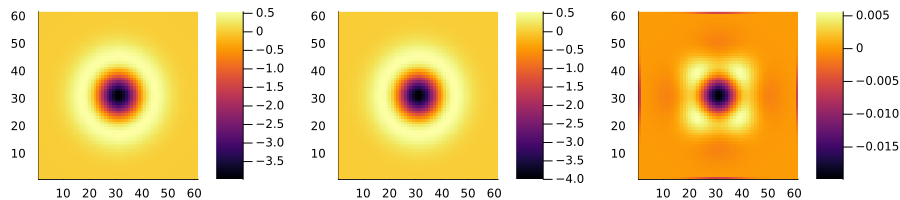

In [147]:
h1 = heatmap(laplacian(phi0, dx))
h2 = heatmap(∇²phi0)
herr = heatmap(∇²phi0 - laplacian(phi0, dx))
plot(h1, h2, herr, layout=(1, 3), size=(900, 200))